## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [ ]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Downloading...
From: https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO
To: /content/coco_imgs.npy
100% 83.0M/83.0M [00:00<00:00, 86.5MB/s]


In [ ]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Downloading...
From (original): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
From (redirected): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW&confirm=t&uuid=a72af9b0-1401-4a46-ac14-d8293dfd35ef
To: /content/coco_captions.npy
100% 415M/415M [00:02<00:00, 150MB/s]


In [ ]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000338581.jpg  
 extracting: val2014/COCO_val2014_000000039656.jpg  
 extracting: val2014/COCO_val2014_000000071667.jpg  
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.j

In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [ ]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=1.71s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [ ]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [ ]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [ ]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [ ]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [ ]:
def accuracy(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    accuracy = 0
    for i, pre in enumerate(predict):
        references = real[i]
        score = bleu_score.sentence_bleu(references, pre)
        accuracy += score
    return accuracy/len(predict)

In [ ]:
def accuracy_v2(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy/len(predict)

predict = ['a cup on a table', 'this music is bad']
real = [['cup placed on a table', 'cup on a table', 'cup on a bench', 'a table', 'a cup'],
        ['this music is bad','this is good music','good music','great songs','singing is great']]
print('accuracy_v2:',accuracy_v2(predict,real))

accuracy_v2: 0.8593041119630842


In [ ]:
import time

In [ ]:
from sklearn.model_selection import train_test_split

#Step 1: Splitting the data into train and test datasets

test_size = 0.2

num_samples = len(image_embeddings)
indices = np.arange(num_samples)
train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=42)

train_image_embeddings = image_embeddings[train_indices]
train_caption_embeddings = caption_embeddings[train_indices]
train_captions_flat = captions_np[train_indices]
train_coco_dset = torch.utils.data.Subset(coco_dset, train_indices)

test_image_embeddings = image_embeddings[test_indices]
test_caption_embeddings = caption_embeddings[test_indices]
test_captions_flat = captions_np[test_indices]
test_coco_dset = torch.utils.data.Subset(coco_dset, test_indices)

**Task 1: Implement the algorithm and compute the bleu score**

In [37]:
def findKNearestImages(k, param_image_embeddings):
  embedding_shape = param_image_embeddings.shape[1]
  index = faiss.IndexFlatIP(embedding_shape)
  index.add(param_image_embeddings)
  dist, neighbour_indices = index.search(param_image_embeddings, k)
  return neighbour_indices

In [38]:
def compute_similarity(image_embedding_i, image_embedding_j):
  return np.dot(image_embedding_i, image_embedding_j) / (np.linalg.norm(image_embedding_i) * np.linalg.norm(image_embedding_j))
def compute_query_vector(image_index, k_neighbors, param_image_embeddings, param_cap_embeddings):
  query_vector = np.zeros(param_cap_embeddings.shape[2])
  for neighbor_index in k_neighbors:
    for caption_index in range(5):
      similarity = compute_similarity(param_image_embeddings[image_index], param_image_embeddings[neighbor_index])
      query_vector += similarity * param_cap_embeddings[neighbor_index][caption_index]
  query_vector /= (len(k_neighbors) * 5)
  return query_vector

In [39]:
def predict_caption(image_index, query_vectors, k_neighbors, param_captions_flat, param_cap_embeddings):
  query_vector = query_vectors[image_index]
  max_similarity = -1
  predicted_caption = None
  for neighbor_index in k_neighbors:
    for caption_index in range(5):
      similarity = np.dot(query_vector, param_cap_embeddings[neighbor_index][caption_index])/ (np.linalg.norm(query_vector) * np.linalg.norm(param_cap_embeddings[neighbor_index][caption_index]))
      if similarity > max_similarity:
          max_similarity = similarity
          predicted_caption = param_captions_flat[neighbor_index][caption_index]
  return predicted_caption

In [42]:
def ImageCaptioning(numOfNeighbours, train=True):
  start_time = time.time()
  img_emb = train_image_embeddings if train else test_image_embeddings
  neighbour_indices = findKNearestImages(numOfNeighbours, train_image_embeddings if train else test_image_embeddings)
  data_without_self_image = np.delete(neighbour_indices, 0, axis=1)
  query_vectors = []
  for image_index in range(img_emb.shape[0]):
    k_neighbors = data_without_self_image[image_index]
    query_vectors.append(compute_query_vector(image_index, k_neighbors, train_image_embeddings if train else test_image_embeddings, train_caption_embeddings if train else test_caption_embeddings))
  predicted_captions = []
  for image_index in range(img_emb.shape[0]):
    k_neighbors = data_without_self_image[image_index]
    predicted_captions.append(predict_caption(image_index, query_vectors, k_neighbors, train_captions_flat if train else test_captions_flat, train_caption_embeddings if train else test_caption_embeddings))
  print("For k =", numOfNeighbours, "accuracy is", accuracy_v2(predicted_captions, train_captions_flat if train else test_captions_flat))
  end_time = time.time()
  print("Required Time:", end_time - start_time)
  return predicted_captions

In [ ]:
ImageCaptioning(5)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

For k = 5 accuracy is 0.06944306469650342
Required Time: 59.35741448402405


**Task 2: Try a few options for k. Record your observations**



In [ ]:
ImageCaptioning(8)

For k = 8 accuracy is 0.0709663725889101
Required Time: 69.84590911865234


In [ ]:
ImageCaptioning(12)

For k = 12 accuracy is 0.07197821153502176
Required Time: 105.26757645606995


In [ ]:
ImageCaptioning(18)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

For k = 18 accuracy is 0.07173325822948359
Required Time: 131.05061101913452


In [ ]:
ImageCaptioning(50)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

For k = 50 accuracy is 0.0652808525120112
Required Time: 330.5552341938019


['men on a field playing a game of frisbee',
 'Person on skis going down a snow covered slope.',
 'A person with a surfboard on a beach.',
 'A passenger plane that is flying in the sky.',
 'A giraffe standing by itself in a grassy area. ',
 'A man is surfing a wave on his surfboard.',
 'A child is blowing out candles on a cake.',
 'A person on a beach with a surfboard.',
 'men on a field playing a game of frisbee',
 'A piece of cake is served on a plate.',
 'A huge assortment of fruit with a lot of bananas.',
 'Man skiers make their way down a snowy ski hill.',
 'a picture of a cellphone on a cellphone',
 'A man on a surfboard riding a wave.',
 'A pizza that is sitting on a plate.',
 'A train that is sitting on the tracks in a station.',
 'A surfer is on the ocean riding a wave.',
 'A small girl is playing frisbee with a man.',
 'a living room with some couches and television inside of it ',
 'A street area next to buildings and people on street.',
 'a tennis player with a racket on a 

In [ ]:
predicted_captions = ImageCaptioning(26)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

For k = 26 accuracy is 0.06921390748936365
Required Time: 203.64448857307434


In [ ]:
predicted_captions = ImageCaptioning(22)

For k = 22 accuracy is 0.07030932511037392
Required Time: 156.80260753631592


In [ ]:
predicted_captions = ImageCaptioning(14)

For k = 14 accuracy is 0.07164702652182386
Required Time: 121.48583722114563


**Observations:**

---

| K value  | Bleu Score | Time Required (in sec) |
|----------|------------|------------------------|
|  8       |  0.0709    |  69.84                 |
|  12      |  0.0719    |  105.26                |
|  18      |  0.0717    |  131.05                |
|  50      |  0.0652    |  330.55                |
|  26      |  0.0692    |  203.64                |
|  22      |  0.0703    |  156.80                |
|  14      |  0.0716    |  121.48                |

Here we observe that Bleu Score value increases with increaing k value till point 14. After that we start to see a drop in the score. K = 12 is optimal from the perspective of both bleu score and time required. Hence choosing k = 12 for further calculations.


**Task 3: For a fixed k, try a few options in the Faiss index factory to speed the computation**

In [ ]:
num_of_neighbours = 12

In [ ]:
import sys
import time
def perform_captioning_optimized(index_factory_options):
  start_time = time.time()
  embedding_shape = train_image_embeddings.shape[1]
  index = faiss.index_factory(embedding_shape, index_factory_options)
  index.train(train_image_embeddings)
  index.add(train_image_embeddings)

  dist, neighbour_indices = index.search(train_image_embeddings, num_of_neighbours)

  data_without_self_image = np.delete(neighbour_indices, 0, axis=1)

  query_vectors = []
  for image_index in range(train_image_embeddings.shape[0]):
    k_neighbors = data_without_self_image[image_index]
    query_vectors.append(compute_query_vector(image_index, k_neighbors, train_image_embeddings, train_caption_embeddings))

  predicted_captions = []
  for image_index in range(train_image_embeddings.shape[0]):
    k_neighbors = data_without_self_image[image_index]
    predicted_captions.append(predict_caption(image_index, query_vectors, k_neighbors, train_captions_flat, train_caption_embeddings))

  print(accuracy_v2(predicted_captions, train_captions_flat))

  end_time = time.time()
  print("Time Required: ", end_time - start_time)
  return predicted_captions

In [ ]:
index_factory_options = "IVF256,PQ32"
predicted_captions = perform_captioning_optimized(index_factory_options)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

0.06537944813237999
Time Required:  248.26891040802002


In [ ]:
index_factory_options = "IVF4096_HNSW32,Flat"
predicted_captions = perform_captioning_optimized(index_factory_options)

0.0490269258710609
Time Required:  116.8915159702301


In [ ]:
index_factory_options = "IMI2x8,PQ32"
predicted_captions = perform_captioning_optimized(index_factory_options)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

0.05303962599819383
Time Required:  259.92149472236633


**Observations:**
Different parameters like index type, quantization technique, index parameter affect the performance of the algorithm. We observe that for our data indexFlatL2 with default parameters works the best.

In [43]:
# Performing final run with test data with K = 12 and eucledian distance
predicted_captions = ImageCaptioning(12, False)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

For k = 12 accuracy is 0.05608675838954848
Required Time: 18.051723957061768


**Task 4: Visualize the result**

In [44]:
import matplotlib.pyplot as plt

def visualizeResult(numOfImages, train=True):
  val_coco_dset = train_coco_dset if train else test_coco_dset
  val_cap_flat = train_captions_flat if train else test_captions_flat
  indices = np.random.choice(len(train_image_embeddings if train else test_image_embeddings), numOfImages, replace=False)
  for i, idx in enumerate(indices):
    img, target = val_coco_dset[idx]

    img = np.transpose(img.numpy(), (1, 2, 0))
    plt.imshow(img)  # Assuming images is a list of image arrays
    plt.title("Predicted: {}\nGround Truth: {}".format(predicted_captions[idx], val_cap_flat[idx]))
    plt.axis('off')
    plt.show()

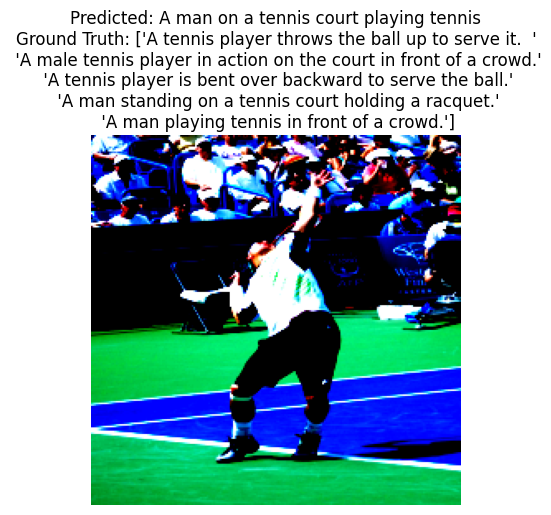

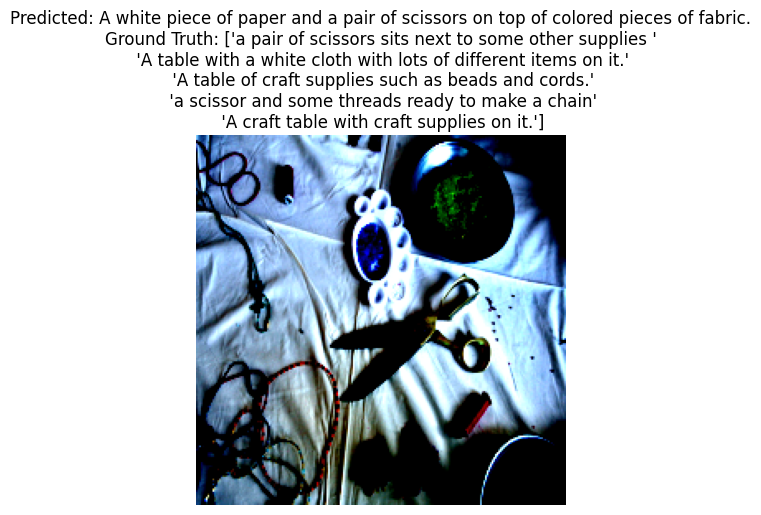

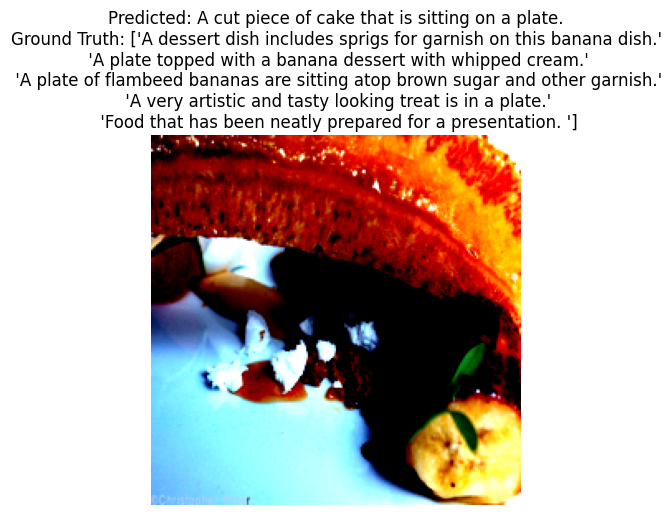

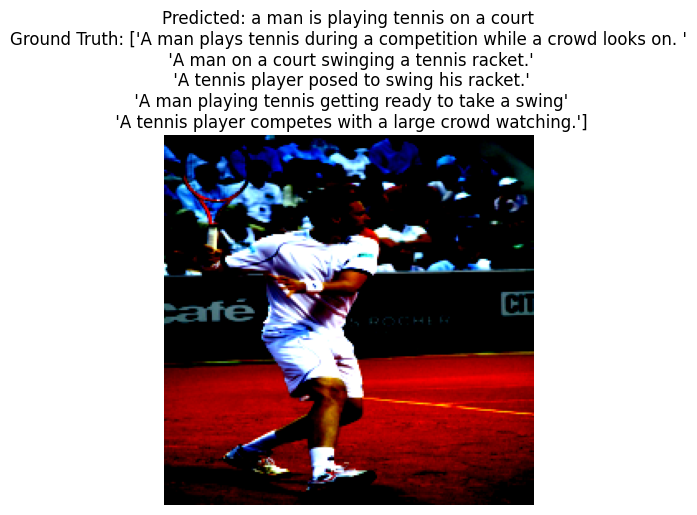

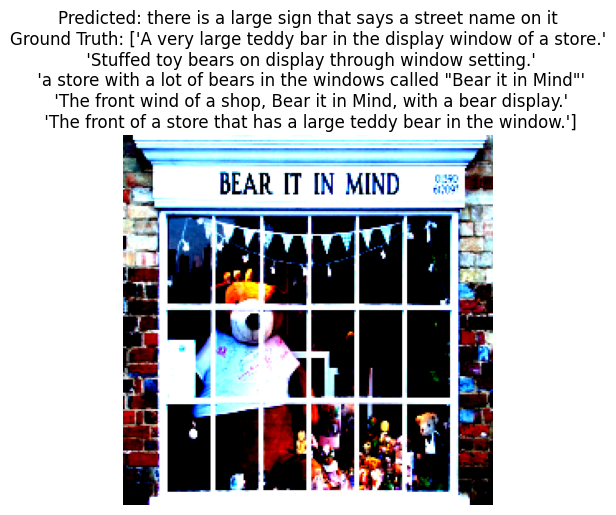

In [45]:
visualizeResult(5, False)